## Stock price prediciton based on historical data, to utilise non deterministic solutions to train or learn what is going on in order to make predicitons. Can be for a single point in time or for a set of future time points.

### Features that are generally helpful in prediction are:-
#### Correlated Assets:- external factors like fiscal, monetary policy, competitors, clients, global economy, geopolitical situation, access to capital. So stock price will be correalted to other things like commodities, FX, broad based indices or fixed income security
#### Technical indicators:- momentum, MA, EMA
#### Fundamental analysis:- ROE, P/E, any news that will have effect on sentiments

### We will try to predict microsoft stock price using both arima models and deep learning model (LSTM)

In [1]:
import pandas as pd
import numpy as np

In [6]:
#loading package for data reader from finance and yahoo
import pandas_datareader.data as web

In [39]:
stock_ticker = ['MSFT', 'IBM', 'GOOGL']
currency_ticker = ['DEXJPUS', 'DEXUSUK']
index_ticker = ['SP500', 'DJIA', 'VIXCLS']
stock_data = web.DataReader(stock_ticker, 'yahoo')
currency_data = web.DataReader(currency_ticker, 'fred')
index_data = web.DataReader(index_ticker, 'fred')

In [90]:
"""We will compute weekly returns, so lag will be of 5 days, curently we have daily data
    To calculate returns, we will be using logarthmic returns.
    Independent variables will be correalted assets, currencies and index data.
    Also, assume the microsoft shares also depend upon it's own return with different lags
    like 5-day, 15-day, 30-day and 60-day"""
return_period = 5
Y = np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period) #we asign the returns to previous dates (It is done because we are doing regression of current values of Microsoft with lagged values of independent values)
Y.name = Y.name[-1] + '_Pred'

In [71]:
X1 = np.log(stock_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(currency_data).diff(return_period)
X3 = np.log(index_data).diff(return_period)
"""Microsoft lagged values"""
X4 = pd.concat([np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT','MSFT_12DT']

In [72]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [93]:
"""Note that values for Y variables will be the next future values
    while values for X will be current, it happend because we use .shift(-return_period)
    during forming the microsoft Y (dependent) data,
    Final data at a interval of 5
    Dataset contains lagged series of correlated shocks, currencies and index.
    It also contains lagged historical returns of MSFT itself."""
dataset = pd.concat([Y,X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:,Y.name]
X = dataset.loc[:, X.columns]

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

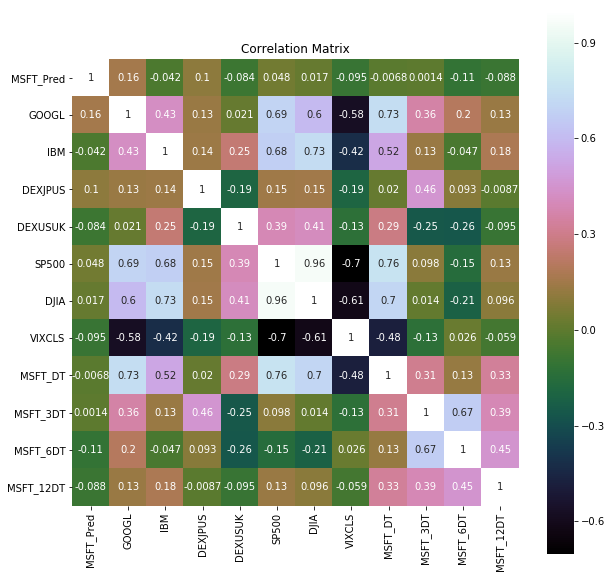

In [99]:
"""Exploratory data analysis"""
correlation = dataset.corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 720x720 with 0 Axes>

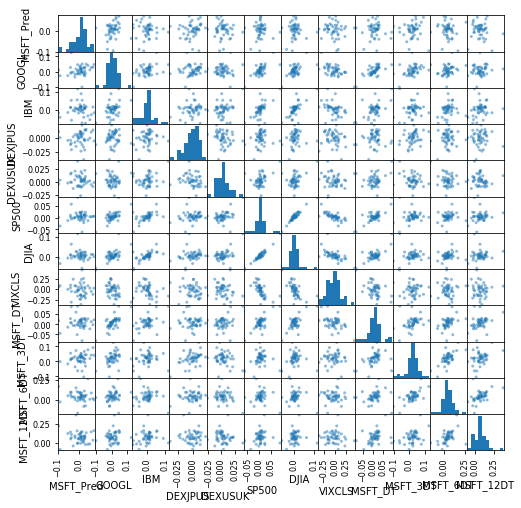

In [101]:
plt.figure(figsize=(10,10))
pd.plotting.scatter_matrix(dataset, figsize=(8,8))
plt.show()
#Not much relation of predicted variable with anything apart from some linear realtionship with its lagged values

In [102]:
"""Time Series analsysis"""
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA